In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from math import sqrt
from os import listdir, getcwd
from os.path import isfile, join
import scipy.io.wavfile
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import figure as fig
from IPython.display import Audio
import seaborn as sns
from tempfile import TemporaryFile
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import pandas as pd

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

C:\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
sampling_frequency = 44100
brachial_audio_dir = join(getcwd(),'..','vsu_tms_site','doppler_audio_samples','brachial')
brachial_wav_filenames = [f for f in listdir(brachial_audio_dir) if isfile(join(brachial_audio_dir,f)) and str(f)[-3:] not in 'txt']
brachial_wav_files = []
carotid_audio_dir = join(getcwd(),'..','vsu_tms_site','doppler_audio_samples','carotid')
carotid_wav_filenames = [f for f in listdir(carotid_audio_dir) if isfile(join(carotid_audio_dir,f)) and str(f)[-3:] not in 'txt']
carotid_wav_files = []

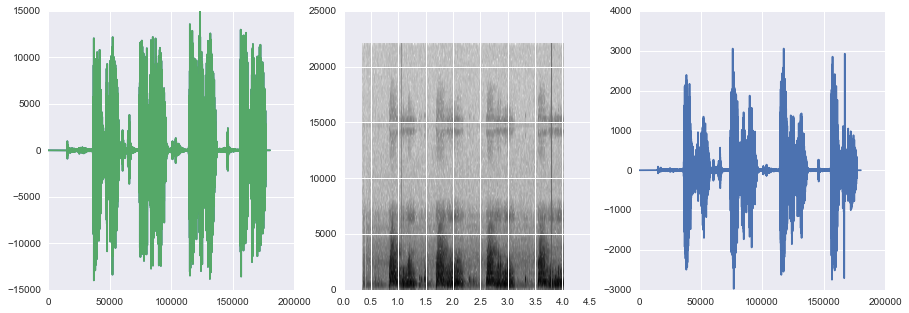

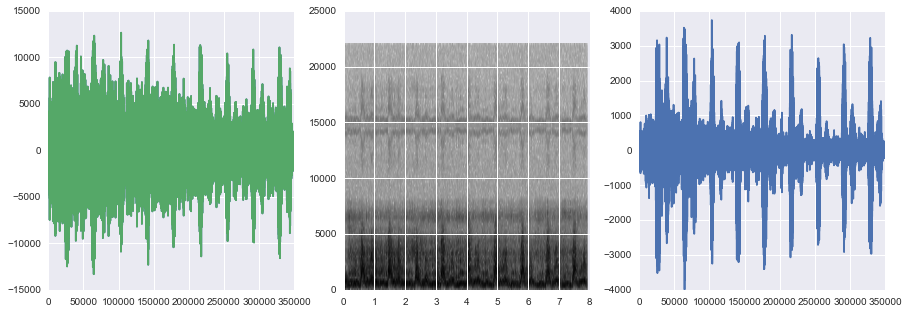

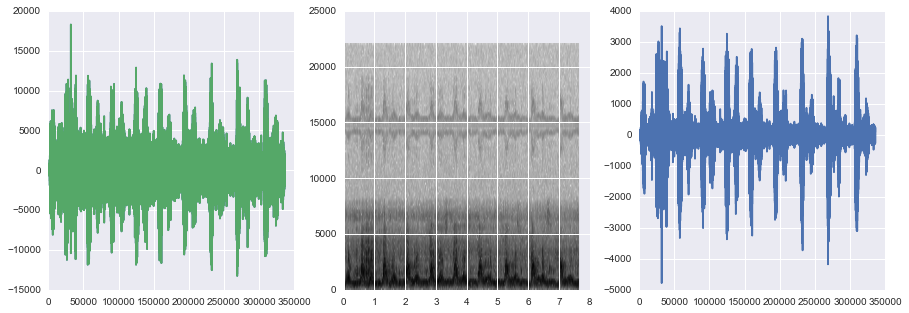

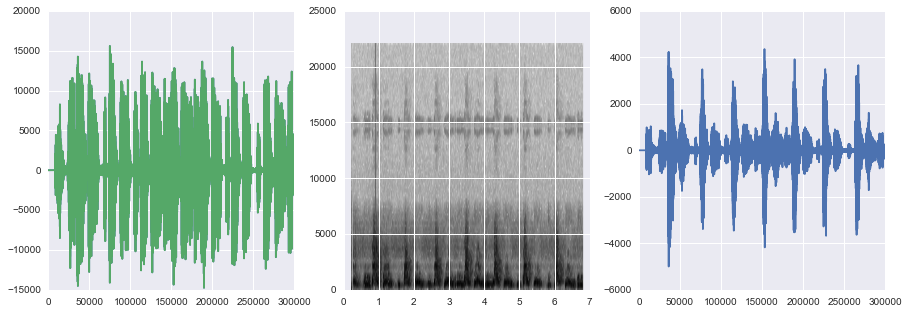

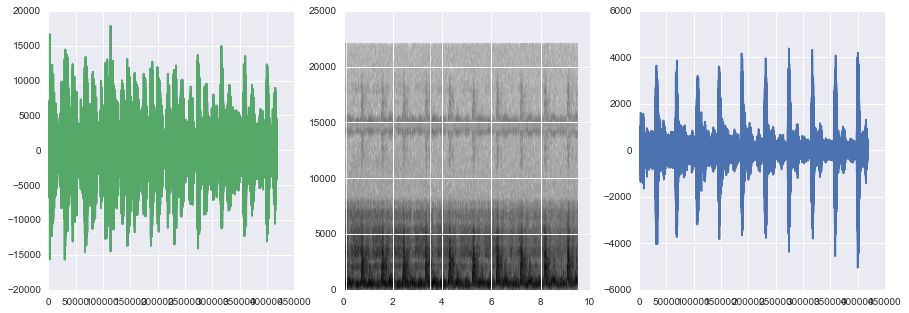

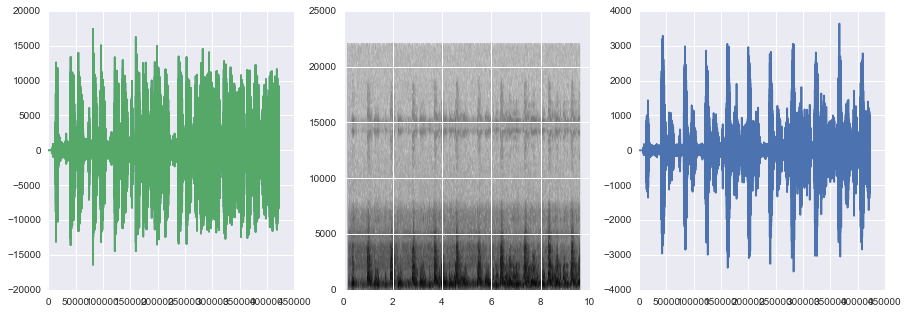

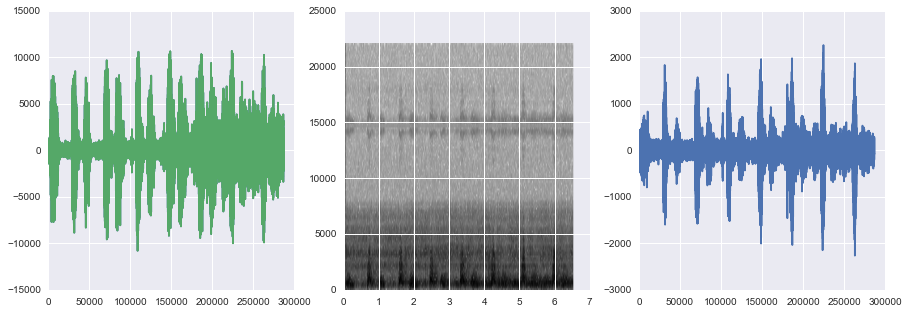

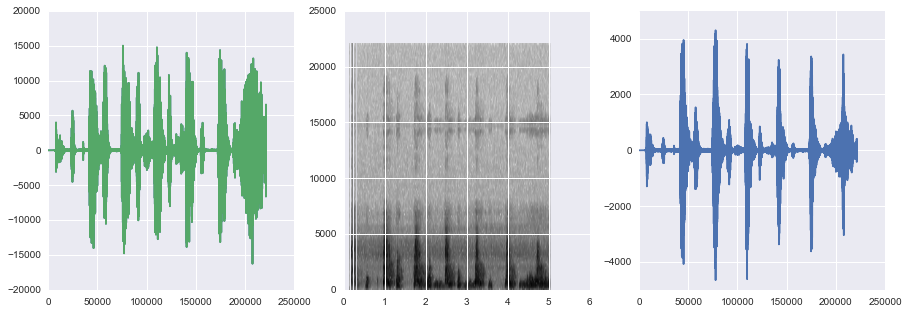

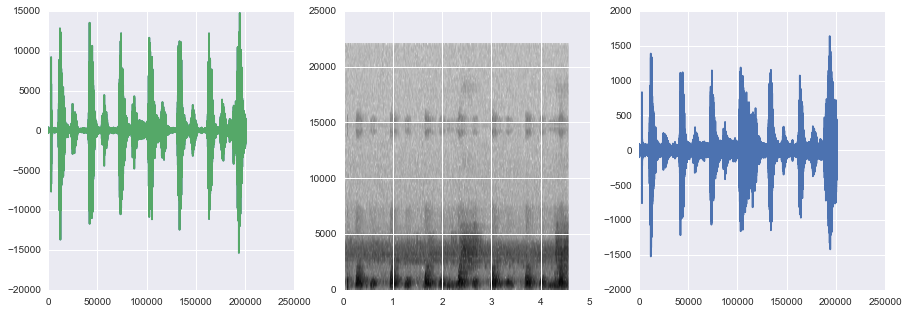

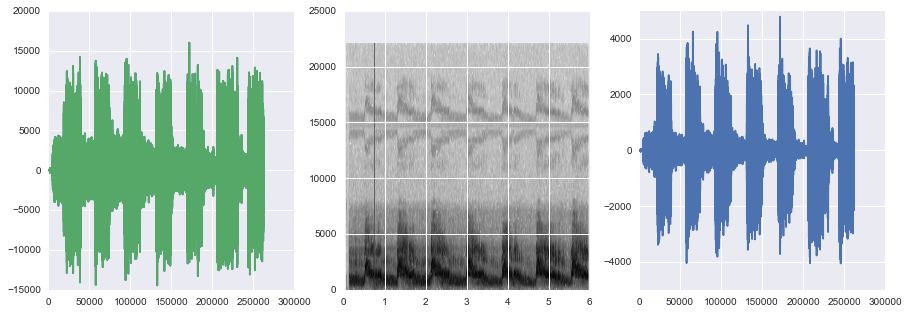

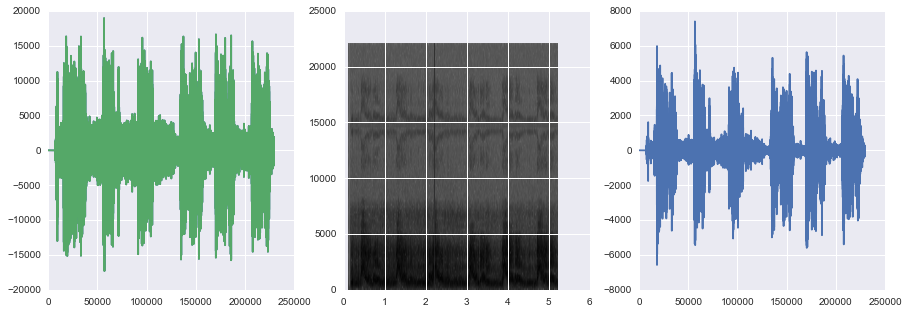

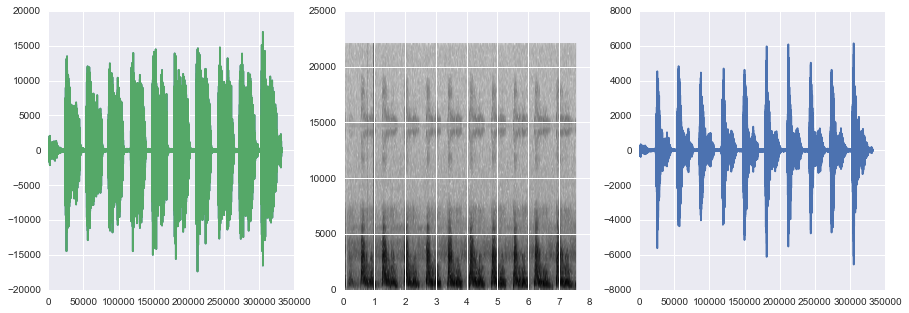

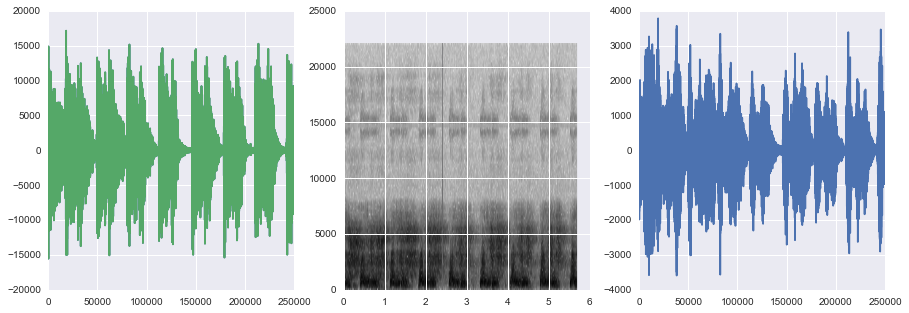

In [4]:
for f in brachial_wav_filenames:
    rate, wf = scipy.io.wavfile.read(join(brachial_audio_dir,f))
    brachial_wav_files.append(wf)
    #xs = [i / float(sampling_frequency) for i in range(0, len(wf[:,0]))]
    f, axarr = plt.subplots(1,3,figsize=(15,5))
    axarr[0].plot(wf)
    audio_out = wf[:,0]
    data, freqs, bins, im = axarr[1].specgram(audio_out, Fs=sampling_frequency)
    axarr[2].plot(np.gradient(wf[:,0]))
    plt.show()
for f in carotid_wav_filenames:
    rate, wf = scipy.io.wavfile.read(join(carotid_audio_dir,f))
    carotid_wav_files.append(wf)
    #xs = [i / float(sampling_frequency) for i in range(0, len(wf[:,0]))]
    f, axarr = plt.subplots(1,3,figsize=(15,5))
    axarr[0].plot(wf)
    audio_out = wf[:,0]
    data, freqs, bins, im = axarr[1].specgram(audio_out, Fs=sampling_frequency)
    axarr[2].plot(np.gradient(wf[:,0]))
    plt.show()

## Waveform detection

In [5]:
def find_waveform_start(wf):
    # Band-pass filtering
    nyq = 0.5 * 44100
    cutoff = 250 / nyq
    b, a = signal.butter(4,cutoff,'highpass')
    wf_filtered = signal.lfilter(b, a, wf)
    cutoff = 1000 / nyq
    b, a = signal.butter(4,cutoff,'lowpass')
    wf_filtered = signal.lfilter(b, a, wf_filtered)
    # Normalise waveform
    peak_amplitude = wf.max()
    wf_normed = wf_filtered / float(peak_amplitude)
    # calculate magnitude
    wf_for_grad = [i if i > 0 else i*(-1) for i in wf_normed]
    # Calculate gradients and normalise them
    wf_grad = np.gradient(wf_for_grad)
    peak_gradient = wf_grad.max()
    wf_grad = wf_grad / float(peak_gradient)
    # Waveform finding logic
    start_indices = []
    amplitude_threshold = 0.2
    gradient_threshold = 0.6
    running_lag_threshold = 20000
    backstep_offset = 1000
    running_lag = running_lag_threshold - backstep_offset
    for i in range(0,len(wf)):
        if (wf[i] > amplitude_threshold and wf_grad[i] > gradient_threshold and running_lag >= running_lag_threshold):
            start_indices[i-backstep_offset] = 1
            running_lag = 0
        else:
            start_indices.append(0)
            running_lag += 1
    return wf, start_indices

In [6]:
brachial_wf_list = []
for f in brachial_wav_files:
    f_wf, start_indices = find_waveform_start(f[:,0])
    true_points = {}
    for i in range(0,len(start_indices)):
        if (start_indices[i] is not 0):
            true_points[str(i)] = True
    start_stop_list = true_points.keys()
    wf_start_stop_points = []
    start_stop_list = [int(i) for i in start_stop_list]
    start_stop_list = sorted(start_stop_list)
    for i in range(0,len(start_stop_list)):
        if (i < len(start_stop_list)-1):
            wf_start_stop_points.append((start_stop_list[i], start_stop_list[i+1]-1))
    for pair in wf_start_stop_points:
        brachial_wf_list.append(f_wf[pair[0]:pair[1]])
carotid_wf_list = []
for f in carotid_wav_files:
    f_wf, start_indices = find_waveform_start(f[:,0])
    true_points = {}
    for i in range(0,len(start_indices)):
        if (start_indices[i] is not 0):
            true_points[str(i)] = True
    start_stop_list = true_points.keys()
    wf_start_stop_points = []
    start_stop_list = [int(i) for i in start_stop_list]
    start_stop_list = sorted(start_stop_list)
    for i in range(0,len(start_stop_list)):
        if (i < len(start_stop_list)-1):
            wf_start_stop_points.append((start_stop_list[i], start_stop_list[i+1]-1))
    for pair in wf_start_stop_points:
        carotid_wf_list.append(f_wf[pair[0]:pair[1]])

## Waveform analysis

Mean, energy, power, variance of signal. Mean and variance of gradients. 

In [7]:
def energy_function(wf_segment):
    energy = 0
    for i in range(0,len(wf_segment)-1):
        energy += wf_segment[i]*wf_segment[i]
    return energy
def power_function(wf_segment,energy):
    power = 0
    power = energy / float(len(wf_segment))
    return power
brachial_metric_list = []
for wf_segment in brachial_wf_list:
    wave_metrics = {}
    wave_metrics['wf'] = wf_segment
    wave_metrics['mean'] = wf_segment.mean()
    wave_metrics['raw_energy'] = energy_function(wf_segment)
    wave_metrics['raw_power'] = power_function(wf_segment, wave_metrics['raw_energy'])
    wave_metrics['raw_variance'] = wf_segment.var()
    wave_metrics['raw_RMS'] = sqrt(np.absolute(wave_metrics['raw_power']))
    wf_segment_gradient = np.absolute(np.gradient(np.absolute(wf_segment)))
    wave_metrics['raw_gradient_variance'] = wf_segment_gradient.var() 
    wave_metrics['raw_gradient_mean'] = wf_segment_gradient.mean()
    wave_metrics['raw_gradient_median'] = np.median(wf_segment_gradient)
    wave_metrics['length_secs'] = len(wf_segment) / float(44100)
    normalised_wf_segment = wf_segment / float(wf_segment.max())
    wave_metrics['normalised_energy'] = energy_function(normalised_wf_segment)
    wave_metrics['normalised_power'] = power_function(normalised_wf_segment, wave_metrics['normalised_energy'])
    wave_metrics['normalised_variance'] = normalised_wf_segment.var()
    wave_metrics['normalised_RMS'] = sqrt(wave_metrics['normalised_power'])
    normalised_wf_segment_gradient = np.absolute(np.gradient(np.absolute(normalised_wf_segment)))
    wave_metrics['normalised_gradient_variance'] = normalised_wf_segment_gradient.var() 
    wave_metrics['normalised_gradient_mean'] = normalised_wf_segment_gradient.mean()
    wave_metrics['normalised_gradient_median'] = np.median(normalised_wf_segment_gradient)
    brachial_metric_list.append(wave_metrics)
carotid_metric_list = []
for wf_segment in carotid_wf_list:
    wave_metrics = {}
    wave_metrics['wf'] = wf_segment
    wave_metrics['mean'] = wf_segment.mean()
    wave_metrics['raw_energy'] = energy_function(wf_segment)
    wave_metrics['raw_power'] = power_function(wf_segment, wave_metrics['raw_energy'])
    wave_metrics['raw_variance'] = wf_segment.var()
    wave_metrics['raw_RMS'] = sqrt(np.absolute(wave_metrics['raw_power']))
    wf_segment_gradient = np.absolute(np.gradient(np.absolute(wf_segment)))
    wave_metrics['raw_gradient_variance'] = wf_segment_gradient.var() 
    wave_metrics['raw_gradient_mean'] = wf_segment_gradient.mean()
    wave_metrics['raw_gradient_median'] = np.median(wf_segment_gradient)
    wave_metrics['length_secs'] = len(wf_segment) / float(44100)
    normalised_wf_segment = wf_segment / float(wf_segment.max())
    wave_metrics['normalised_energy'] = energy_function(normalised_wf_segment)
    wave_metrics['normalised_power'] = power_function(normalised_wf_segment, wave_metrics['normalised_energy'])
    wave_metrics['normalised_variance'] = normalised_wf_segment.var()
    wave_metrics['normalised_RMS'] = sqrt(wave_metrics['normalised_power'])
    normalised_wf_segment_gradient = np.absolute(np.gradient(np.absolute(normalised_wf_segment)))
    wave_metrics['normalised_gradient_variance'] = normalised_wf_segment_gradient.var() 
    wave_metrics['normalised_gradient_mean'] = normalised_wf_segment_gradient.mean()
    wave_metrics['normalised_gradient_median'] = np.median(normalised_wf_segment_gradient)
    carotid_metric_list.append(wave_metrics)

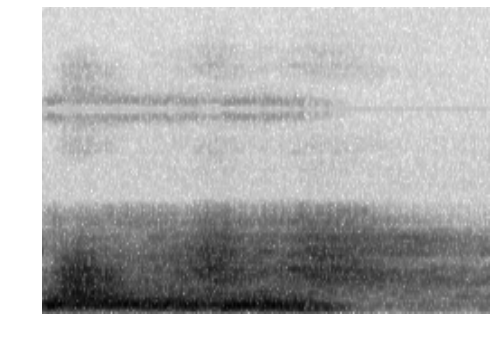

In [8]:
counter = 0
img_store = {}
final_df = pd.DataFrame()
for w in brachial_metric_list:
    for k, v in w.iteritems():
        if (k == 'wf'):
            continue
        final_df.loc[counter, k] = v
    final_df.loc[counter, 'class'] = 'brachial'
    data, freqs, bins, im = plt.specgram(w['wf'], Fs=sampling_frequency)
    plt.grid(False)
    xlim(0,max(bins))
    ylim(0,max(freqs))
    plt.axis('off')
    with TemporaryFile() as tmpfile:
        plt.savefig(tmpfile,bbox_inches='tight') # File position is at the end of the file.
        tmpfile.seek(0) # Rewind the file. (0: the beginning of the file)
        im = Image.open(tmpfile)
        npa = np.asarray(im) # array indexed by [y][x] where [0][0] is bottom-left corner (cartesian)
    img_store[str(counter)] = npa[:200,:200,0]
    counter += 1
for w in carotid_metric_list:
    for k, v in w.iteritems():
        if (k == 'wf'):
            continue
        final_df.loc[counter, k] = v
    final_df.loc[counter, 'class'] = 'carotid'
    data, freqs, bins, im = plt.specgram(w['wf'], Fs=sampling_frequency)
    plt.grid(False)
    xlim(0,max(bins))
    ylim(0,max(freqs))
    plt.axis('off')
    with TemporaryFile() as tmpfile:
        plt.savefig(tmpfile,bbox_inches='tight') # File position is at the end of the file.
        tmpfile.seek(0) # Rewind the file. (0: the beginning of the file)
        im = Image.open(tmpfile)
        npa = np.asarray(im) # array indexed by [y][x] where [0][0] is bottom-left corner (cartesian)
    img_store[str(counter)] = npa[:200,:200,0]
    counter += 1

In [9]:
final_df

,raw_variance,raw_gradient_mean,normalised_gradient_mean,normalised_power,normalised_gradient_variance,raw_gradient_median,normalised_energy,raw_power,normalised_variance,raw_RMS,raw_energy,normalised_gradient_median,normalised_RMS,raw_gradient_variance,length_secs,mean,class
0,6.667712e+06,174.567545,0.014349,0.045049,0.000509,53.50,1689.367385,1519.649236,0.045049,38.982679,56988366.0,0.004398,0.212247,75348.810843,0.850363,-1.045625,brachial
1,7.512062e+06,188.365852,0.015465,0.050637,0.000584,43.50,2059.087047,1763.147797,0.050637,41.989853,71696642.0,0.003571,0.225026,86639.839938,0.922086,-1.017116,brachial
2,8.214018e+06,190.300320,0.012762,0.036944,0.000409,38.00,1522.123542,1497.827189,0.036944,38.701772,61711978.0,0.002548,0.192208,90882.558427,0.934263,-1.042887,brachial
3,8.665287e+06,211.461135,0.022323,0.096561,0.000293,181.00,2027.397266,187.073157,0.096562,13.677469,3927788.0,0.019107,0.310743,26304.678429,0.476100,-1.087207,brachial
4,9.492040e+06,393.097478,0.034926,0.074929,0.001410,256.50,1702.616964,193.455046,0.074932,13.908812,4395879.0,0.022790,0.273732,178674.928710,0.515261,-2.075210,brachial
5,1.018092e+07,337.208263,0.027360,0.067016,0.001069,209.50,1475.212894,169.409940,0.067021,13.015757,3729221.0,0.016998,0.258874,162332.205036,0.499161,-0.613547,brachial
6,8.434888e+06,310.170582,0.031914,0.089297,0.000902,230.50,1801.828044,210.019923,0.089297,14.492064,4237782.0,0.023716,0.298825,85248.818905,0.457551,0.612499,brachial
7,7.747240e+06,267.846922,0.021185,0.048467,0.000578,184.00,1155.644496,284.156643,0.048467,16.856946,6775431.0,0.014554,0.220152,92405.268506,0.540680,-2.640874,brachial
8,6.736617e+06,183.791935,0.023792,0.112884,0.000372,150.50,3029.015277,136.743748,0.112887,11.693748,3669245.0,0.019482,0.335982,22221.436752,0.608458,3.603921,brachial
9,7.430138e+06,256.909595,0.021772,0.053362,0.000690,165.00,1991.512847,301.132767,0.053362,17.353177,11238576.0,0.013983,0.231002,96100.380911,0.846281,-1.444843,brachial


### Modelling using derived features

In [59]:
X = final_df.ix[:,final_df.columns != 'class']
y = final_df['class']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y.ravel(),test_size=0.1)
training_indices = list(X_train.index)
print(training_indices)
model = RandomForestClassifier()
model.fit(X=X_train, y=y_train)
predictions = model.predict(X_test)
print(predictions)
print(y_test)
features = zip(list(X_train.columns),list(model.feature_importances_))
features

[50, 19, 5, 90, 10, 52, 41, 80, 32, 71, 76, 16, 75, 49, 62, 34, 31, 13, 68, 27, 79, 64, 84, 15, 43, 57, 29, 87, 48, 23, 63, 36, 95, 53, 74, 78, 30, 46, 70, 3, 83, 25, 38, 22, 47, 67, 55, 72, 35, 66, 58, 39, 14, 97, 0, 65, 94, 12, 24, 11, 8, 59, 40, 1, 73, 85, 45, 82, 7, 69, 6, 33, 28, 81, 44, 17, 51, 26, 92, 88, 37, 86, 42, 89, 18, 93, 54, 21]
['carotid' 'brachial' 'brachial' 'carotid' 'carotid' 'carotid' 'brachial'
 'brachial' 'carotid' 'brachial']
['brachial' 'brachial' 'brachial' 'carotid' 'carotid' 'carotid' 'brachial'
 'brachial' 'brachial' 'brachial']


[('raw_variance', 0.077899178652205706),
 ('raw_gradient_mean', 0.1626875399534656),
 ('normalised_gradient_mean', 0.043679263700301584),
 ('normalised_power', 0.060024399097140989),
 ('normalised_gradient_variance', 0.018205031709104529),
 ('raw_gradient_median', 0.017565350227187672),
 ('normalised_energy', 0.06781960543711836),
 ('raw_power', 0.072054819083733471),
 ('normalised_variance', 0.027089486497207278),
 ('raw_RMS', 0.045755952312024076),
 ('raw_energy', 0.025963121151328584),
 ('normalised_gradient_median', 0.053146924281237184),
 ('normalised_RMS', 0.036001228564485684),
 ('raw_gradient_variance', 0.2119744316227555),
 ('length_secs', 0.031126895933598252),
 ('mean', 0.049006771777105509)]

### Modelling using neual nets on images

In [56]:
X_train = []
X_test = [] 
y_train = []
y_test = []
for r, v in final_df.iterrows():
    if r in training_indices:
        X_train.append(img_store[str(r)])
        y_train.append(final_df.loc[r,'class'])
    else:
        X_test.append(img_store[str(r)])
        y_test.append(final_df.loc[r,'class'])
convert_class_defs = {'brachial':0.0, 'carotid':1.0}
y_train = [convert_class_defs[i] for i in y_train]
y_train = np.array(y_train)
y_train = y_train.astype(np.int32)
X_train = np.array(X_train)

In [57]:
X_train = X_train.reshape(-1, 1, 200, 200)
train_test_size = int(0.8*X_train.shape[0])
layers0 = [
    # layer dealing with the input data
    (layers.InputLayer, {'shape': (None,1,200,200)}),

    # first stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 8, 'filter_size': 2}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 4, 'filter_size': 3}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (layers.DenseLayer, {'num_units': 4}),
    (layers.DropoutLayer, {}),
    (layers.DenseLayer, {'num_units': 4}),

    # the output layer
    (layers.DenseLayer, {'num_units': 2, 'nonlinearity': lasagne.nonlinearities.softmax}),
]

net1 = NeuralNet(
    layers=layers0,
    # layer parameters:

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.001,
    update_momentum=0.9,
    
    max_epochs=5,
    verbose=1,
)

# Train the network
net1.fit(X_train, y_train)

# Neural Network with 37230 learnable parameters

## Layer information

  #  name        size
---  ----------  ---------
  0  input0      1x200x200
  1  conv2d1     8x199x199
  2  maxpool2d2  8x99x99
  3  conv2d3     4x97x97
  4  maxpool2d4  4x48x48
  5  dense5      4
  6  dropout6    4
  7  dense7      4
  8  dense8      2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.82003       4.67042      0.38969      0.66667  2.39s
      2       3.40504       0.69256      4.91657      0.66667  2.14s
      3       0.69260       0.69225      1.00051      0.66667  1.98s
      4       0.69230       0.69187      1.00062      0.66667  2.17s
      5       0.69194       0.69144      1.00073      0.66667  2.23s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x09480910>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x09480850>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 200, 200)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 2, 'num_filters': 8}), (<class 'lasagne.layers.pool.MaxPool2DLayer'>, {'pool_size': 2}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'nu...agne.layers.dense.DenseLayer'>, {'num_units': 2, 'nonlinearity': <function softmax at 0x09205330>})],
     loss=None, max_epochs=5, more_params={},
     objective=<function objective at 0x09482AF0>,
     objective_loss_function=<function categorical_crossentropy at 0x0937E6B0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x0B783620>],
     on_training_finished=[],
     on_training_started=[<no

In [13]:
print(y_test)
net1.predict(np.array(X_test).reshape(-1, 1, 200, 200))

['brachial', 'brachial', 'brachial', 'brachial', 'brachial', 'brachial', 'brachial', 'carotid', 'carotid', 'carotid']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])